In [1]:
%cd /mnt/i/Yuki/workspace/exercises/nlp_100_knock

/mnt/i/Yuki/workspace/exercises/nlp_100_knock


https://nlp100.github.io/ja/ch06.html

# 準備

In [2]:
import itertools
import collections
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_path = 'Question_50_59/news_aggregator_data_set/newsCorpora.csv'
train_data_path = 'Question_50_59/news_aggregator_data_set/train.txt'
valid_data_path = 'Question_50_59/news_aggregator_data_set/valid.txt'
test_data_path = 'Question_50_59/news_aggregator_data_set/test.txt'

In [4]:
data = []
with open(data_path, 'r') as f:
    for line in f.readlines():
        data.append(line.split('\t'))

columns = [
    'ID',
    'TITLE',
    'URL',
    'PUBLISHER',
    'CATEGORY',
    'STORY',
    'HOSTNAME',
    'TIMESTAMP',
]

data_table = pd.DataFrame(data, columns=columns)

# 問題

## 50. データの入手・整形

In [5]:
publishers_to_use = [
    'Reuters',
    'Huffington Post',
    'Businessweek',
    'Contactmusic.com',
    'Daily Mail',
]

extracted = data_table[data_table['PUBLISHER'].isin(publishers_to_use)].reset_index(drop=True)
extracted['CATEGORY'] = extracted['CATEGORY'].replace({
    'b': 'business',
    't': 'science technology',
    'e': 'entertainment',
    'm': 'health',
})

data_count = len(extracted)
train_data_count = int(data_count * 0.8)
valid_data_count = int(data_count * 0.1)
test_data_count = data_count - train_data_count - valid_data_count

extracted = extracted.loc[np.random.permutation(data_count).tolist()]
extracted = extracted[['TITLE', 'CATEGORY']]
train_data = extracted.iloc[:train_data_count].reset_index(drop=True)
valid_data = extracted.iloc[train_data_count:train_data_count + valid_data_count].reset_index(drop=True)
test_data = extracted.iloc[train_data_count + valid_data_count:].reset_index(drop=True)

In [6]:
train_data.to_csv(train_data_path, encoding='utf8', index=False, sep='\t')
valid_data.to_csv(valid_data_path, encoding='utf8', index=False, sep='\t')
test_data.to_csv(test_data_path, encoding='utf8', index=False, sep='\t')

In [7]:
print(f'Train Data Count: {len(train_data)}')
print(f'Valid Data Count: {len(valid_data)}')
print(f'Test Data Count: {len(test_data)}')

Train Data Count: 10684
Valid Data Count: 1335
Test Data Count: 1337


## 51. 特徴量抽出

In [8]:
class TextVectorizer:
    def __init__(self):
        self.counter = collections.Counter()

    def register(self, documents):
        self.counter.update(itertools.chain.from_iterable(documents))
        tokens, _ = list(zip(*sorted(self.counter.items(), key=lambda x: x[1], reverse=True)))
        self.token_to_index = dict((token, i) for i, token in enumerate(tokens))
        self.index_to_token = dict(enumerate(tokens))

    def get_index(self, token):
        return self.token_to_index[token]

    def get_document_index(self, documents, max_token=500):
        values = np.zeros((len(documents), max_token))
        for i, doc in enumerate(documents):
            for token in doc:
                if token in self.token_to_index and self.token_to_index[token] < max_token:
                    values[i, self.token_to_index[token]] += 1

        return values

    def get_token(self, index):
        return self.index_to_token[index]

In [9]:
train_documents = [text.split() for text in train_data['TITLE'].tolist()]
valid_documents = [text.split() for text in valid_data['TITLE'].tolist()]
test_documents = [text.split() for text in test_data['TITLE'].tolist()]

tv = TextVectorizer()
tv.register(test_documents)

train_X = tv.get_document_index(train_documents, 200)
valid_X = tv.get_document_index(valid_documents, 200)
test_X = tv.get_document_index(test_documents, 200)

In [10]:
category_to_label = TextVectorizer()
category_to_label.register([train_data['CATEGORY'].tolist()])

train_y = np.array([category_to_label.get_index(category) for category in train_data['CATEGORY'].tolist()])
valid_y = np.array([category_to_label.get_index(category) for category in valid_data['CATEGORY'].tolist()])
test_y = np.array([category_to_label.get_index(category) for category in test_data['CATEGORY'].tolist()])

train_X = np.random.randn(100, 200)
train_y = np.random.randint(0, 5, 100)

valid_X = np.random.randn(100, 200)
valid_y = np.random.randint(0, 5, 100)

test_X = np.random.randn(100, 200)
test_y = np.random.randint(0, 5, 100)

In [11]:
train_data_count = train_X.shape[0]
valid_data_count = valid_X.shape[0]
test_data_count = test_X.shape[0]

feature_dim = train_X.shape[1]
label_count = 4

## 52. 学習

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x, axis=1):
    h = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return h / np.sum(h, axis=axis, keepdims=True)

class logistic_regression_model:
    def __init__(self, input_dim, output_dim, reg_lambda=0):
        self.output_dim = output_dim
        self.reg_lambda = reg_lambda
        self.W = np.random.randn(input_dim, self.output_dim)
        self.b = np.random.randn(self.output_dim)

    def train(self, X, y):
        self.X = X.copy()
        self.z = softmax(np.matmul(X, self.W) + self.b)
        self.y = y.copy()

        return self.z.copy()
    
    def backward(self, lr=1e-2):
        grad_out = (self.z - np.eye(self.output_dim)[self.y]) / self.X.shape[0]
        grad_W = np.matmul(self.X.T, grad_out) - self.W * self.reg_lambda / self.X.shape[0]
        grad_b = np.sum(grad_out, axis=0)
        
        self.W -= lr * grad_W
        self.b -= lr * grad_b
    
    def predict(self, X):
        return softmax(np.matmul(X, self.W) + self.b)

In [13]:
model = logistic_regression_model(feature_dim, label_count, reg_lambda=0)

In [14]:
epochs = []
accuracies = []
for epoch in range(10000):
    probs = model.train(train_X, train_y)
    model.backward(lr=1e-1)
    
    if (epoch + 1) % 100 == 0:
        preds = np.argmax(probs, axis=1)
        correct_count = np.sum(train_y == preds)
        accuracies.append(correct_count / train_y.shape[0])
        epochs.append(epoch + 1)

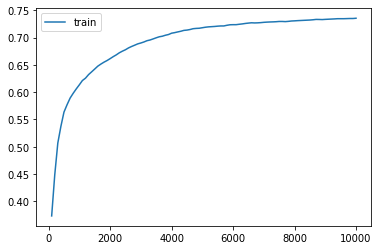

In [15]:
plt.plot(epochs, accuracies, label='train')
plt.legend()

plt.show()

## 53. 予測

In [16]:
probs = model.predict(test_X)
probs

array([[0.01782046, 0.94433415, 0.02491498, 0.01293042],
       [0.48019731, 0.46292605, 0.01939805, 0.03747859],
       [0.76567608, 0.08744043, 0.10754351, 0.03933998],
       ...,
       [0.68862904, 0.1480524 , 0.09206321, 0.07125535],
       [0.91591528, 0.01117525, 0.00666967, 0.06623979],
       [0.98118853, 0.01415721, 0.0011843 , 0.00346996]])

## 54. 正解率の計測

In [17]:
probs = model.predict(train_X)
preds = np.argmax(probs, axis=1)
correct_count = np.sum(train_y == preds)

print(f'Accuracy: {correct_count / train_y.shape[0] * 100:.2f} % ({correct_count}/{train_y.shape[0]})')

Accuracy: 73.56 % (7859/10684)


In [18]:
probs = model.predict(test_X)
preds = np.argmax(probs, axis=1)
correct_count = np.sum(test_y == preds)

print(f'Accuracy: {correct_count / test_y.shape[0] * 100:.2f} % ({correct_count}/{test_y.shape[0]})')

Accuracy: 72.40 % (968/1337)


## 55. 混同行列の作成

In [19]:
probs = model.predict(train_X)
preds = np.argmax(probs, axis=1)
correct_count = np.sum(train_y == preds)

train_cm = np.zeros((label_count, label_count), dtype=np.int)
for true, pred in zip(train_y, preds):
    train_cm[true, pred] += 1
train_cm

array([[4000,  419,   52,   20],
       [ 568, 3601,   51,   29],
       [ 592,  369,  220,   26],
       [ 354,  308,   37,   38]])

In [20]:
probs = model.predict(test_X)
preds = np.argmax(probs, axis=1)
correct_count = np.sum(test_y == preds)

test_cm = np.zeros((label_count, label_count), dtype=np.int)
for true, pred in zip(test_y, preds):
    test_cm[true, pred] += 1
test_cm

array([[486,  61,   9,   2],
       [ 78, 435,   8,   5],
       [ 67,  47,  42,   5],
       [ 43,  42,   2,   5]])

## 56. 適合率，再現率，F1スコアの計測

In [21]:
recall = np.sum(np.eye(label_count) * test_cm, axis=1) / (np.sum(test_cm, axis=1) + 1e-18)
precision = np.sum(np.eye(label_count) * test_cm, axis=0) / (np.sum(test_cm, axis=0) + 1e-18)
fvalue = 2 * recall * precision / (recall + precision + 1e-18)

for i in range(label_count):
    print(f'Label {i}')
    print(f'Recall: {recall[i]:.4f}')
    print(f'Precision: {precision[i]:.4f}')
    print(f'F-Value: {fvalue[i]:.4f}')
    print()

print('Macro Average')
print(f'Recall: {np.mean(recall):.4f}')
print(f'Precision: {np.mean(precision):.4f}')
print(f'F-Value: {np.mean(fvalue):.4f}')

Label 0
Recall: 0.8710
Precision: 0.7211
F-Value: 0.7890

Label 1
Recall: 0.8270
Precision: 0.7436
F-Value: 0.7831

Label 2
Recall: 0.2609
Precision: 0.6885
F-Value: 0.3784

Label 3
Recall: 0.0543
Precision: 0.2941
F-Value: 0.0917

Macro Average
Recall: 0.5033
Precision: 0.6118
F-Value: 0.5105


## 57. 特徴量の重みの確認

In [22]:
w_index = np.argsort(model.W, axis=0)[::-1]
for i in range(label_count):
    largest_tokens = [tv.get_token(idx) for idx in w_index[:10, i]]
    smallest_tokens = [tv.get_token(idx) for idx in w_index[:-10-1:-1, i]]
    print(f'Largest 10 Feature of Label "{category_to_label.get_token(i)}" : {largest_tokens}')
    print(f'Smallest 10 Feature of Label "{category_to_label.get_token(i)}" : {smallest_tokens}')
    print()

Largest 10 Feature of Label "business" : ['GLOBAL', 'near', 'Billion', 'FOREX-Euro', 'Rate', 'Outlook', 'top', 'bln', 'Euro', 'FOREX-Dollar']
Smallest 10 Feature of Label "business" : ['Why', 'Ryan', 'Jennifer', 'that', 'Jay', "'The", 'And', 'Gwyneth', 'Simpson', 'A']

Largest 10 Feature of Label "entertainment" : ['Michael', 'Chris', 'Kardashian', 'Met', 'Kanye', 'Justin', 'Kim', 'Music', 'Her', 'she']
Smallest 10 Feature of Label "entertainment" : ['business', 'Fitch', 'that', 'Bank', 'ECB', 'Climate', 'ahead', 'Ukraine', 'Rates', 'May']

Largest 10 Feature of Label "science technology" : ['Google', 'Music', 'Outlook', 'Climate', 'Chris', 'Apple', 'UN', 'Into', 'To', 'All']
Smallest 10 Feature of Label "science technology" : ['Draghi', 'Simpson', 'strong', 'Why', 'His', 'IPO', 'fall', 'Ukraine', 'profit', 'UK']

Largest 10 Feature of Label "health" : ['WRAPUP', 'June', 'Music', 'Harris', 'Life', 'have', 'set', 'are', 'lower', 'But']
Smallest 10 Feature of Label "health" : ['Against',

## 58. 正則化パラメータの変更

In [23]:
def get_accuracy(X, y):
    probs = model.predict(X)
    preds = np.argmax(probs, axis=1)
    correct_count = np.sum(y == preds)
    accuracy = correct_count / y.shape[0]
    
    return accuracy

In [24]:
reg_lambdas = 0.1 ** (np.arange(6))
train_accuracies = []
valid_accuracies = []
test_accuracies = []
for reg_lambda in reg_lambdas:
    model = logistic_regression_model(feature_dim, label_count, reg_lambda=reg_lambda)
    for _ in range(10000):
        model.train(train_X, train_y)
        model.backward(lr=1e-1)

    train_accuracies.append(get_accuracy(train_X, train_y))
    valid_accuracies.append(get_accuracy(valid_X, valid_y))
    test_accuracies.append(get_accuracy(test_X, test_y))

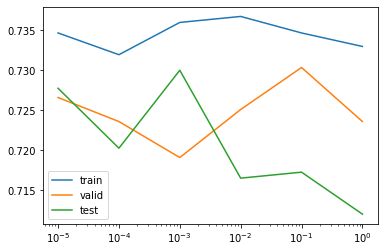

In [25]:
plt.plot(reg_lambdas, train_accuracies, label='train')
plt.plot(reg_lambdas, valid_accuracies, label='valid')
plt.plot(reg_lambdas, test_accuracies, label='test')

plt.xscale('log')
plt.legend()

plt.show()

## 59. ハイパーパラメータの探索

In [26]:
reg_lambdas = 0.1 ** (np.arange(6))

best_score = None
best_lambda = None
best_model = None
for reg_lambda in reg_lambdas:
    model = logistic_regression_model(feature_dim, label_count, reg_lambda=reg_lambda)
    for _ in range(10000):
        model.train(train_X, train_y)
        model.backward(lr=1e-1)

    score = get_accuracy(train_X, train_y)
    if best_score is None or best_score < score:
        best_score = score
        best_lambda = reg_lambda
        best_model = deepcopy(model)

In [27]:
print(f'Best Lambda: {best_lambda}')
print(f'Best Accuracy: {best_score:.4f}')

Best Lambda: 0.0010000000000000002
Best Accuracy: 0.7379
